# **Inception Models CNN classifiers on CIFAR-10 dataset**

In Convolutional Neural Networks (CNNs), a large part of the work is to choose the right layer to apply, among the most common options (1x1 filter, 3x3 filter 5x5 filter or max-pooling). All we need is to find the optimal local construction and to repeat it spatially.

As these “Inception modules” are stacked on top of each other, their output correlation statistics are bound to vary: as features of higher abstraction are captured by higher layers, their spatial concentration is expected to decrease suggesting that the ratio of 3×3 and 5×5 convolutions should increase as we move to higher layers.

In [0]:
!pip install keras_sequential_ascii

  Created wheel for keras-sequential-ascii: filename=keras_sequential_ascii-0.1.1-cp36-none-any.whl size=3062 sha256=c9a5d283b83691e431aaeb753c3d3750af6972cf4aeb7d4cf3ee5b3697075c7c
  Stored in directory: /root/.cache/pip/wheels/f5/8d/81/912666dff82a923ce423a7e797cd75f54271c7031512cdb282
Successfully built keras-sequential-ascii


In [0]:
# REQUIRED IMPORTS

from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Activation
from keras.layers import MaxPooling2D, AveragePooling2D, Dropout
from keras.layers.merge import concatenate
from keras.utils import plot_model
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras.models import load_model


Using TensorFlow backend.


## **Dataset Loading & Preproccesing**

### Data Load

In [0]:
# Download the CIFAR-10 datasets

(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

# number of classes of the label
num_classes = 10

170500096/170498071 [==============================] - 2s 0us/step


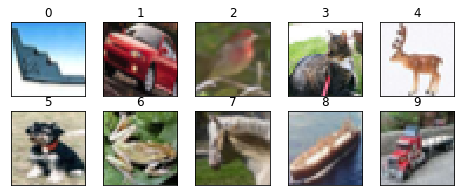

In [0]:
# Print figure with 10 random images from each
 
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::],(0,1,2))   
    ax.set_title(i)
    plt.imshow(im)
plt.show()

### Data Preprocessing

In [0]:

# Converting label to 1 hot encodings 

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# preprocessing on images
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

In [0]:
# return class name given a 1 hot encoding label

def class_name(y_label):
  y_name = ""
  index = np.where(y_label == 1)[0]
  if   index == 0:  y_name = "airplane"
  elif index == 1:  y_name = "automobile"
  elif index == 2:  y_name = "bird"
  elif index == 3:  y_name = "cat"
  elif index == 4:  y_name = "deer"
  elif index == 5:  y_name = "dog"
  elif index == 6:  y_name = "frog"
  elif index == 7:  y_name = "horse"
  elif index == 8:  y_name = "ship"
  elif index == 9:  y_name = "truck"
  return y_name


In [0]:
# Testing

print(len(y_train))

# print(y_train[0])


y = [0,1,0,0,0,0,0,0,0,0]
y = np.array(y)

print(class_name(y))

50000
automobile


## **Inception v1: Naive Version**

Having filters with multiple sizes operate on the same level? The network essentially would get a bit “wider” rather than “deeper”. The authors designed the inception module to reflect the same.

The “naive” inception module performs convolution on an input, with 3 different sizes of filters (1x1, 3x3, 5x5). Additionally, max pooling is also performed. The outputs are concatenated and sent to the next inception module.

https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/?fbclid=IwAR2xSxMWC4nNQCcVGfFRadDCaP0qDno-a3QBUjXoygh5Wd1ZjvSGuWuA2HE


### Naive Inception Block

In [0]:
# function for creating a naive inception block
'''
  layer_in  : input layer to the inception module
  f1, f2, f3: number of filters for 1x1, 3x3, 5x5 convolution
  layer_out : the concatinate output layer from  
'''

def naive_inception_module(layer_in, f1, f2, f3):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
	# 5x5 conv
	conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out

### Model Creation

In [0]:

# define model input
visible = Input(shape=(32, 32, 3))

# add inception module
layer = naive_inception_module(visible, 64, 128, 32)

#flatten the resulted inception module
flat = Flatten()(layer)

# Dense layer
fc1 = Dense(1000, activation='relu')(flat)

# define mode output
output = Dense(10, activation='softmax')(fc1)


# create model
naive_model = Model(inputs=visible, outputs=output)


In [0]:
# summarize model

naive_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 128)  3584        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 32)   2432        input_1[0][0]                    
____________________________________________________________________________________________

In [0]:
# Vizualizing model structure
 
sequential_model_to_ascii_printout(naive_model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     32   32    3
          InputLayer     |   -------------------         0     0.0%
                       #####     32   32    3
              Conv2D    \|/  -------------------       256     0.0%
                relu   #####     32   32   64
              Conv2D    \|/  -------------------      3584     0.0%
                relu   #####     32   32  128
              Conv2D    \|/  -------------------      2432     0.0%
                relu   #####     32   32   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     32   32    3
         Concatenate   ????? -------------------         0     0.0%
                       #####     32   32  227
             Flatten   ||||| -------------------         0     0.0%
                       #####      232448
               Dense   XXXXX ------------------- 232449000   100.0%
                rel

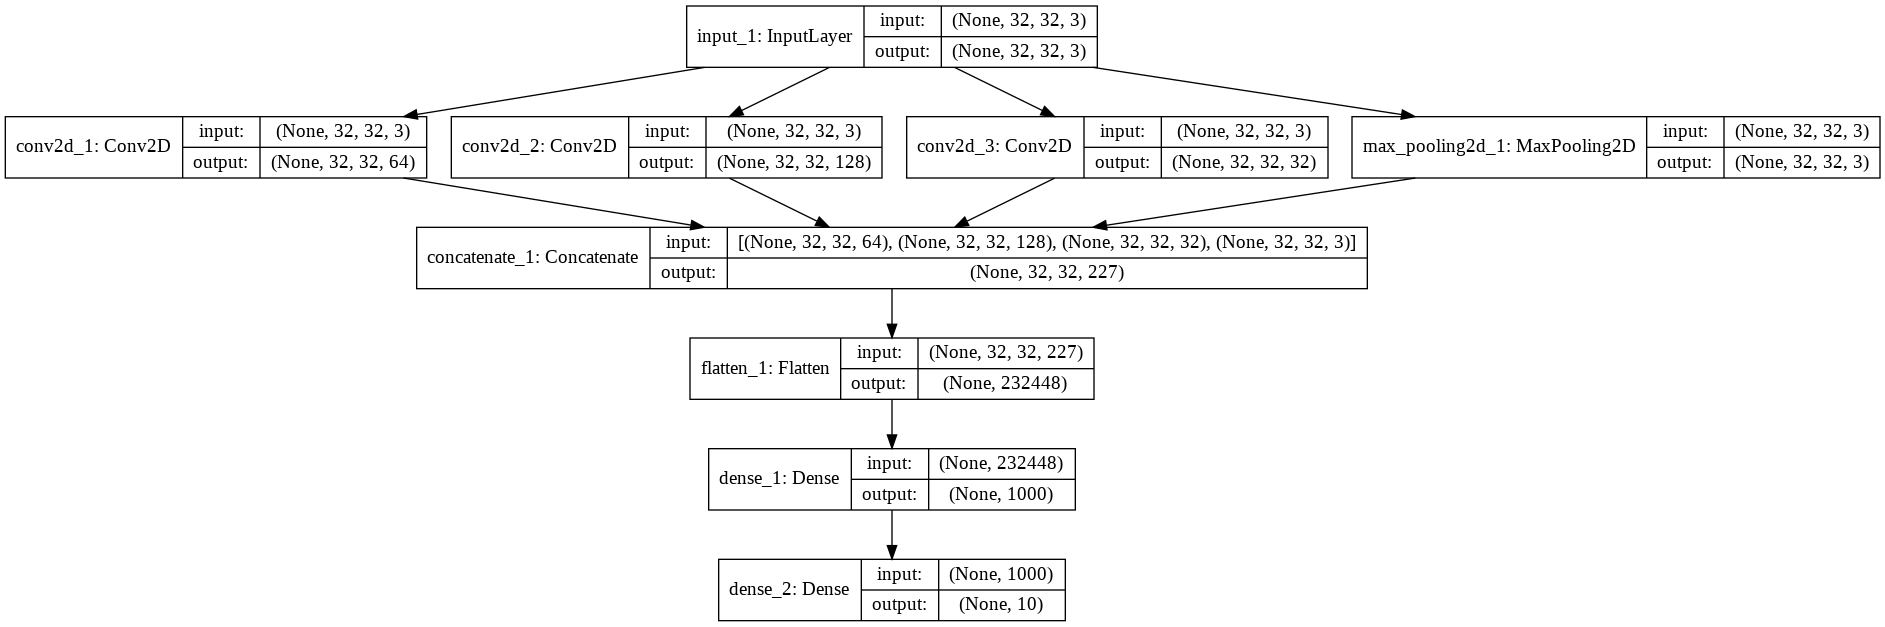

In [0]:
# plot model architecture

plot_model(naive_model, show_shapes=True, to_file='naive_inception_module.png')


In [0]:
# Compile the model

naive_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
# Fitting the model

batch_size = 32   #64
epochs = 10     #150

# Train model (use 10% of training set as validation set)

naive_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, shuffle=True)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 40000 samples, validate on 10000 samples
Epoch 1/10





40000/40000 [==============================] - 222s 6ms/step - loss: 1.8379 - acc: 0.3395 - val_loss: 1.6550 - val_acc: 0.4111
Epoch 2/10
40000/40000 [==============================] - 212s 5ms/step - loss: 1.5573 - acc: 0.4449 - val_loss: 1.4866 - val_acc: 0.4762
Epoch 3/10
40000/40000 [==============================] - 211s 5ms/step - loss: 1.4143 - acc: 0.4927 - val_loss: 1.3949 - val_acc: 0.5068
Epoch 4/10
40000/40000 [==============================] - 211s 5ms/step - loss: 1.3176 - acc: 0.5305 - val_loss: 1.3100 - val_acc: 0.5325
Epoch 5/10
40000/40000 [==============================] - 211s 5ms/step - loss: 1.2406 - acc: 0.5557 - val_loss: 1.2676 - val_acc: 0.5540
Epoch 6/10
40000/40000 [==============================] - 211s 5ms/step - loss: 1.1767 - acc: 0.5809 - val_loss: 1.2955 - val_acc: 0.5385
Epoch 7/10
 4928/400

KeyboardInterrupt: ignored

In [0]:
# save trained model

naive_model.save('naive_model.h5')  # creates a HDF5 file 'my_model.h5'


In [0]:
# returns a compiled model identical to the trained one

naive_model = load_model('naive_model.h5')

### Results

In [0]:
# Evaluate the model on Test set

scores = naive_model.evaluate(x_test, y_test)
print("\nTest %s: %.2f%%" % (naive_model.metrics_names[1], scores[1]*100))

10000/10000 [==============================] - 8s 803us/step

Test acc: 56.05%


In [0]:
# output on some test images

# select 10 random examples from test set
random_test_index = []
Xtest =[]
for i in range(0,10):
	val = randint(0, len(x_test))
	while( val in random_test_index):
		val = randint(0, len(x_test))
	random_test_index = [random_test_index val]
	Xtest = [Xtest x_test[random_test_index]]

# make a prediction
y_predicted = naive_model.predict_classes(Xtest)

# show the inputs and predicted outputs
for i in range(len(Xtest)):
	print("X=%s, Predicted=%s" % (Xnew[i], ynew[i]))

In [0]:
# Plots for training and testing process: loss and accuracy
 
plt.figure(0)
plt.plot(naive_model.history['acc'],'r')
plt.plot(naive_model.history['val_acc'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(naive_model.history['loss'],'r')
plt.plot(naive_model.history['val_loss'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
  
plt.show()

TypeError: ignored

<Figure size 432x288 with 0 Axes>

## **Inception v2: Dimension Reduction**

Deep neural networks are computationally expensive. To make it cheaper, the authors limit the number of input channels by adding an extra 1x1 convolution before the 3x3 and 5x5 convolutions. 

Though adding an extra operation may seem counterintuitive, 1x1 convolutions are far more cheaper than 5x5 convolutions, and the reduced number of input channels also help. Do note that however, the 1x1 convolution is introduced after the max pooling layer, rather than before.

### Dimension Reduction Inception Block

In [0]:
# function for creating a dimension reduction inception block
'''
  layer_in  : input layer to the inception module
  f1, f2, f3: number of filters for 1x1, 3x3, 5x5 convolution
  layer_out : the concatinate output layer from  
'''

def dim_red_inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv
	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out

### SIMPLE Model Creation

In [0]:

# define model input
visible = Input(shape=(32, 32, 3))

# add inception module
layer = dim_red_inception_module(visible, 64, 96, 128, 16, 32, 32)

#flatten the resulted inception module
flat = Flatten()(layer)

# Dense layer
fc1 = Dense(1000, activation='relu')(flat)

# define mode output
output = Dense(10, activation='softmax')(fc1)

# create model
dim_red_model = Model(inputs=visible, outputs=output)


In [0]:
# summarize model

dim_red_model.summary()


In [0]:
# plot model architecture

plot_model(dim_red_model, show_shapes=True, to_file='naive_inception_module.png')


In [0]:
# Compile the model

dim_red_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
# Fitting the model

batch_size = 32   #64
epochs = 3      #150

# Train model (use 10% of training set as validation set)

dim_red_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, shuffle=True)


In [0]:
# Vizualizing model structure
 
sequential_model_to_ascii_printout(dim_red_model)

#### Results

In [0]:
# Evaluate the model on Test set

scores = dim_red_model.evaluate(x_test, y_test)
print("\nTest %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [0]:
# Plots for training and testing process: loss and accuracy
 
plt.figure(0)
plt.plot(dim_red_model.history['acc'],'r')
plt.plot(dim_red_model.history['val_acc'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(dim_red_model.history['loss'],'r')
plt.plot(dim_red_model.history['val_loss'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
  
plt.show()

###LARGE Model Creation

In [0]:
def dr_inception_module(layer_in, f1, f1for3, f2, f1for5, f3, f1formax):
  # 1x1 conv
  conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
  # 1x1 conv 
  conv1for3 = Conv2D(f1for3, (1,1), padding='same', activation='relu')(layer_in)
  #zeropadding
  #zeropad3 = ZeroPadding2D(padding=(1, 1))(conv1for3)
  # 3x3 conv
  conv3 = Conv2D(f2, (1,1), padding='same', activation='relu')(conv1for3)
	# 1x1 conv
  conv1for5 = Conv2D(f1for5, (1,1), padding='same', activation='relu')(layer_in)
  #zeropadding
  #zeropad5 = ZeroPadding2D(padding=(1, 1))(conv1for5)
	# 5x5 conv
  conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(conv1for5)
	# 3x3 max pooling
  pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
 	# 1x1 conv
  conv1formax = Conv2D(f1formax, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
  layer_out = concatenate([conv1, conv3, conv5, conv1formax], axis=-1)
  return layer_out

In [0]:
from keras.layers.core import Layer
from keras import backend as K
if K.backend() == 'theano':
    import theano.tensor as T
elif K.backend() == 'tensorflow':
    import tensorflow as tf
else:
    raise NotImplementedError

class LRN(Layer):

    def __init__(self, alpha=0.0001, k=1, beta=0.75, n=5, **kwargs):
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n
        super(LRN, self).__init__(**kwargs)

    def call(self, x, mask=None):
        b, ch, r, c = x.shape
        half_n = self.n // 2 # half the local region
        input_sqr = K.square(x) # square the input
        if K.backend() == 'theano':
            # make an empty tensor with zero pads along channel dimension
            zeros = T.alloc(0., b, ch + 2*half_n, r, c)
            # set the center to be the squared input
            input_sqr = T.set_subtensor(zeros[:, half_n:half_n+ch, :, :], input_sqr)
        else:
            input_sqr = tf.pad(input_sqr, [[0, 0], [half_n, half_n], [0, 0], [0, 0]])
        scale = self.k # offset for the scale
        norm_alpha = self.alpha / self.n # normalized alpha
        for i in range(self.n):
            scale += norm_alpha * input_sqr[:, i:i+ch, :, :]
        scale = scale ** self.beta
        x = x / scale
        return x

    def get_config(self):
        config = {"alpha": self.alpha,
                  "k": self.k,
                  "beta": self.beta,
                  "n": self.n}
        base_config = super(LRN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
from __future__ import print_function
import imageio
from PIL import Image
import numpy as np
import keras

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Concatenate, Reshape, Activation,GlobalAveragePooling2D
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import SGD


# creates GoogLeNet a.k.a. Inception v1 (Szegedy, 2015)
input = Input(shape=(32, 32, 3))

conv1_7x7_s2 = Conv2D(64, (7,7), strides=(2,2), padding='valid', activation='relu')(input)

#pool1_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(conv1_7x7_s2)
#pool1_norm1 = LRN(name='pool1/norm1')(pool1_3x3_s2)

#conv2_3x3_reduce = Conv2D(64, (1,1), padding='same', activation='relu')(pool1_3x3_s2)
#conv2_3x3 = Conv2D(192, (3,3), padding='same', activation='relu')(conv2_3x3_reduce)
#conv2_norm2 = LRN(name='conv2/norm2')(conv2_3x3)
#pool2_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(conv2_3x3)
inception_3a_output = dr_inception_module(conv1_7x7_s2 ,64,96,128,16,32,32) 



inception_3b_output =  dr_inception_module(inception_3a_output ,128,128,192,32,96,64) 


pool3_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid')(inception_3b_output)


inception_4a_output = dr_inception_module(pool3_3x3_s2,192,96,208,16,48,64)

loss1_ave_pool = AveragePooling2D(pool_size=(3,3))(inception_4a_output)
#loss1_conv = Conv2D(128, (1,1), padding='same', activation='relu')(loss1_ave_pool)
loss1_flat = Flatten()(loss1_ave_pool)
drop = Dropout(rate = 0.4)(loss1_flat)
#loss1_fc = Dense(1000, activation='relu')(drop)
loss1_classifier = Dense(1000, activation='relu')(drop)
loss1_classifier_act = Dense(10, activation='softmax',name='loss1_classifier_act')(loss1_classifier)



inception_4b_output = dr_inception_module(inception_4a_output,160,112,224,24,64,64)


inception_4c_output = dr_inception_module(inception_4b_output,128,128,256,24,64,64)


inception_4d_output =  dr_inception_module(inception_4c_output,112,144,288,32,64,64)





loss2_ave_pool = AveragePooling2D(pool_size=(3,3))(inception_4d_output)
#loss2_conv = Conv2D(128, (1,1), padding='same', activation='relu')(loss2_ave_pool)
loss2_flat = Flatten()(loss2_ave_pool)
drop2 = Dropout(rate = 0.4)(loss2_flat)
#loss2_fc = Dense(1000, activation='relu')(drop2)
loss2_classifier = Dense(1000, activation='relu')(drop2)
loss2_classifier_act = Dense(10, activation='softmax', name = 'loss2_classifier_act')(loss2_classifier)

inception_4e_output = dr_inception_module(inception_4d_output,256,160,320,32,128,128)


pool4_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid')(inception_4e_output)


inception_5a_output = dr_inception_module(pool4_3x3_s2,256,160,320,32,128,128)


inception_5b_output = dr_inception_module(inception_5a_output,384,192,384,48,128,128)


pool5_2x2_s1 = AveragePooling2D(pool_size=(2,2))(inception_5b_output)
loss3_flat = Flatten()(pool5_2x2_s1)
drop3 = Dropout(rate = 0.4)(loss3_flat)
loss3_classifier = Dense(1000, activation='relu')(drop3)
loss3_classifier_act = Dense(10, activation='softmax', name ='loss3_classifier_act')(loss3_classifier)



In [0]:
googlenet = Model(inputs=input, outputs=[loss3_classifier_act,loss1_classifier_act,loss2_classifier_act])

In [0]:

losses = {
	"loss3_classifier_act": "categorical_crossentropy",
	"loss1_classifier_act": "categorical_crossentropy",
  "loss2_classifier_act": "categorical_crossentropy"
}

lossWeights = {
    "loss3_classifier_act": 0.4,
	  "loss1_classifier_act": 0.3,
    "loss2_classifier_act": 0.3
    }
 
googlenet.compile(optimizer='sgd', loss=losses, loss_weights=lossWeights, metrics=['accuracy'])

In [0]:

googlenet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 112, 112, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 53, 53, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 26, 26, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
pool1/norm1 (LRN)               (None, 26, 26, 64)   0           max_pooling2d_1[0][0]            
____________________________________________________________________________________________

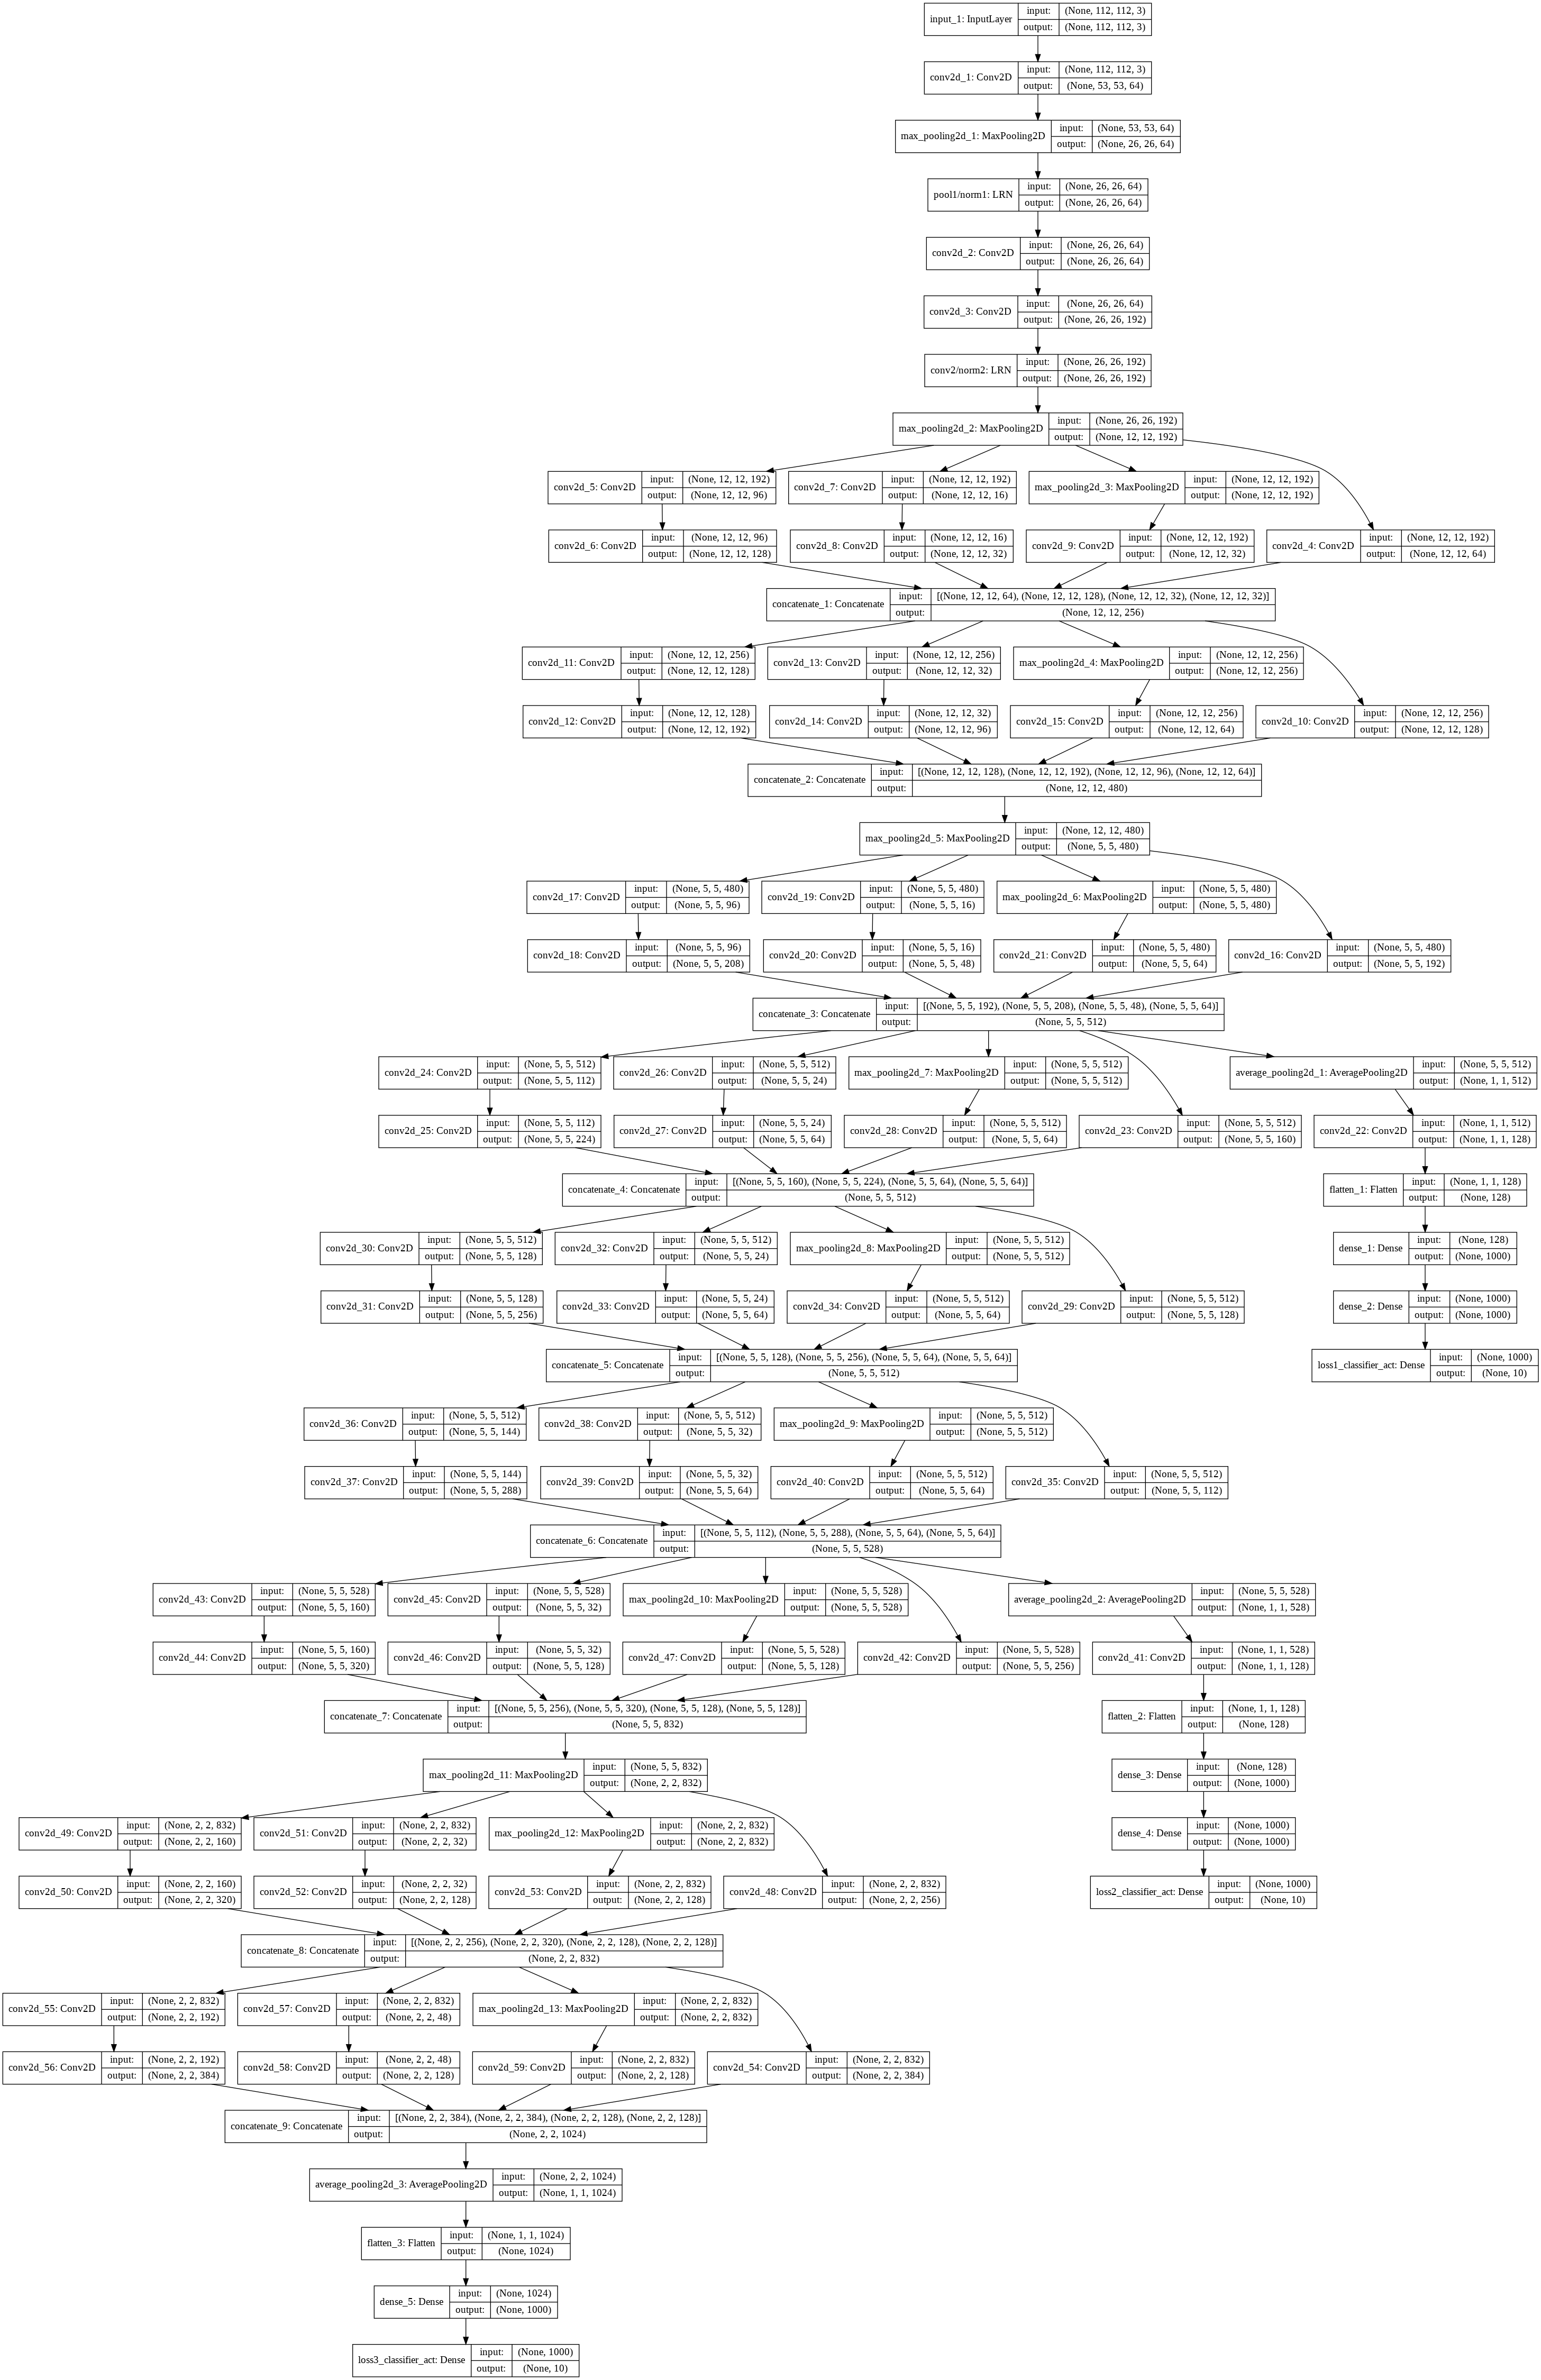

In [0]:
plot_model(googlenet, show_shapes=True, to_file='googlenet.png')

In [0]:
# Fitting the model

batch_size = 32   #64
epochs = 10     #150
# Train model (use 10% of training set as validation set)
googlenet.fit(x_train,{"loss3_classifier_act":y_train, "loss1_classifier_act":y_train, "loss2_classifier_act":y_train}, epochs=epochs, batch_size=batch_size, validation_split=0.1, shuffle=True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 108s 2ms/step - loss: 1.0198 - loss3_classifier_act_loss: 0.9661 - loss1_classifier_act_loss: 1.0941 - loss2_classifier_act_loss: 1.0169 - loss3_classifier_act_acc: 0.6567 - loss1_classifier_act_acc: 0.6105 - loss2_classifier_act_acc: 0.6389 - val_loss: 1.0235 - val_loss3_classifier_act_loss: 1.0056 - val_loss1_classifier_act_loss: 1.0635 - val_loss2_classifier_act_loss: 1.0075 - val_loss3_classifier_act_acc: 0.6466 - val_loss1_classifier_act_acc: 0.6280 - val_loss2_classifier_act_acc: 0.6446
Epoch 2/10
45000/45000 [==============================] - 108s 2ms/step - loss: 0.9848 - loss3_classifier_act_loss: 0.9283 - loss1_classifier_act_loss: 1.0654 - loss2_classifier_act_loss: 0.9796 - loss3_classifier_act_acc: 0.6732 - loss1_classifier_act_acc: 0.6222 - loss2_classifier_act_acc: 0.6524 - val_loss: 1.1991 - val_loss3_classifier_act_loss: 1.2413 - val_loss1_classifier_act_loss: 1.1

KeyboardInterrupt: ignored

In [0]:
from google.colab import drive

# load an image from google drive
drive.mount('/content/drive')
src = '/content/drive/My Drive/'

# serialize model to JSON
model_json = googlenet.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
googlenet.save_weights(src+"model.h5")
print("Saved model to disk")

#files.download("model.h5")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Saved model to disk


In [0]:
# Evaluate the model on Test set

scores = googlenet.evaluate(x_test, {"loss3_classifier_act":y_test, "loss1_classifier_act":y_test, "loss2_classifier_act":y_test})
print("\nTest %s: %.2f%%" % (googlenet.metrics_names[1], scores[1]*100))

10000/10000 [==============================] - 7s 673us/step

Test loss3_classifier_act_loss: 94.44%


## **Inception V3**

### V3 Inception Blocks builder Function

In [0]:
def inception_module_V3_A(layer_in, f1, f2, f3, f4):
  # 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 1* 3x3 conv
	conv2 = Conv2D(f2, (1,1), padding='same', activation='relu')(layer_in)
	conv2 = Conv2D(f2, (3,3), padding='same', activation='relu')(conv2)
	# 2* 3x3 conv
	conv3 = Conv2D(f3, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f3, (3,3), padding='same', activation='relu')(conv3)
	conv3 = Conv2D(f3, (3,3), padding='same', activation='relu')(conv3)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv2, conv3, pool], axis=-1)
	return layer_out

In [0]:
def inception_module_V3_B(layer_in, filter_size, f1, f2, f3, f4):
  # 1x1 conv
  conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 1* 3x3 conv
  conv2 = Conv2D(f2, (1,1), padding='same', activation='relu')(layer_in)
  conv2 = Conv2D(f2, (1,filter_size), padding='same', activation='relu')(conv2)
  conv2 = Conv2D(f2, (filter_size,1), padding='same', activation='relu')(conv2)
	# 2* 3x3 conv
  conv3 = Conv2D(f3, (1,1), padding='same', activation='relu')(layer_in)
  conv3 = Conv2D(f3, (1,filter_size), padding='same', activation='relu')(conv3)
  conv3 = Conv2D(f3, (filter_size,1), padding='same', activation='relu')(conv3)
  conv3 = Conv2D(f3, (1,filter_size), padding='same', activation='relu')(conv3)
  conv3 = Conv2D(f3, (filter_size,1), padding='same', activation='relu')(conv3)
	# 3x3 max pooling
  pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  pool = Conv2D(f4, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
  layer_out = concatenate([conv1, conv2, conv3, pool], axis=-1)
  return layer_out

In [0]:
def inception_module_V3_C(layer_in, f1, f2, f3, f4):
  # 1x1 conv
  conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
  # 1* 3x3 conv
  conv2 = Conv2D(f2, (1,1), padding='same', activation='relu')(layer_in)
  conv2 = Conv2D(f2, (3,3), padding='same', activation='relu')(conv2)
  conv2_1 = Conv2D(f2, (1,3), padding='same', activation='relu')(conv2)
  conv2_2 = Conv2D(f2, (3,1), padding='same', activation='relu')(conv2)

	# 2* 3x3 conv
  conv3 = Conv2D(f3, (1,1), padding='same', activation='relu')(layer_in)
  conv3_1 = Conv2D(f3, (1,3), padding='same', activation='relu')(conv3)
  conv3_2 = Conv2D(f3, (3,1), padding='same', activation='relu')(conv3)
	# 3x3 max pooling
  pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  pool = Conv2D(f4, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
  layer_out = concatenate([conv1, conv2_1, conv2_2, conv3_1, conv3_2, pool], axis=-1)
  return layer_out

In [0]:
def auxiliary_output(input_layer,Name):
  pool = AveragePooling2D(pool_size=(3, 3))(input_layer)
  #flatten the resulted inception module
  dense1 = Flatten()(pool)
  #drop out
  drop_1 = Dropout(rate=0.4)(dense1)
  # Dense layer
  dense2 = Dense(1000, activation='relu')(drop_1)
  dense3 = Dense(1000, activation='relu')(dense2)
  # define mode output
  out = Dense(10, activation='softmax',name=Name)(dense3)
  return out


### SIMPLE Model Creation

In [0]:
# define model input
visible = Input(shape=(32, 32, 3))
# add inception block 1
layer = inception_module_V3_A(visible, 64, 96, 128, 32)
#flatten the resulted inception module
flat = Flatten()(layer)
# Dense layer
fc1 = Dense(1000, activation='relu')(flat)
# define mode output
output = Dense(10, activation='softmax')(fc1)
# create model
inception_V3 = Model(inputs=visible, outputs= output)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 128)  512         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 32, 32, 96)   384         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 32, 128)  147584      conv2d_11[0][0]                  
____________________________________________________________________________________________

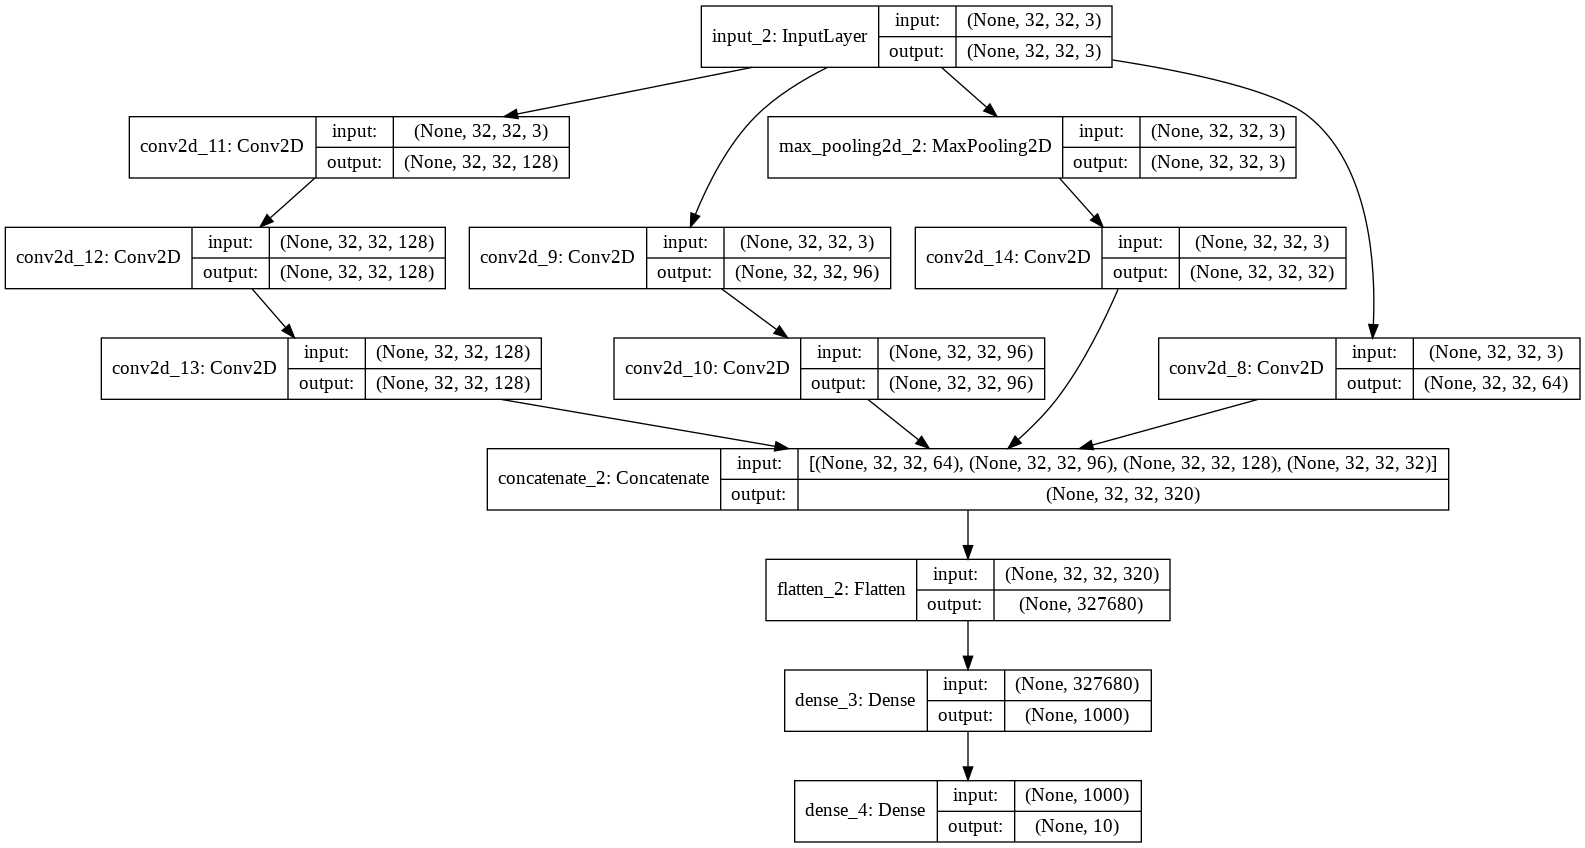

In [0]:
# summarize model
inception_V3.summary()

# plot model architecture
plot_model(inception_V3, show_shapes=True, to_file='inception_moduleV3.png')


In [0]:
inception_V3.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# Fitting the model

batch_size = 32   #64
epochs = 10      #150

# Train model (use 10% of training set as validation set)

inception_V3.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 45000 samples, validate on 5000 samples
Epoch 1/3





45000/45000 [==============================] - 378s 8ms/step - loss: 1.7914 - acc: 0.3634 - val_loss: 1.7292 - val_acc: 0.3658
Epoch 2/3
45000/45000 [==============================] - 373s 8ms/step - loss: 1.5016 - acc: 0.4678 - val_loss: 1.4735 - val_acc: 0.4820
Epoch 3/3
  544/45000 [..............................] - ETA: 6:01 - loss: 1.3414 - acc: 0.5239

KeyboardInterrupt: ignored

#### Results

In [0]:
# Evaluate the model on Test set

scores = inception_V3.evaluate(x_test, y_test)
print("\nTest %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [0]:
# Plots for training and testing process: loss and accuracy
 
plt.figure(0)
plt.plot(inception_V3.history['acc'],'r')
plt.plot(inception_V3.history['val_acc'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(inception_V3.history['loss'],'r')
plt.plot(inception_V3.history['val_loss'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
  
plt.show()

####MEDIUM Model Creation

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_852 (Conv2D)             (None, 15, 15, 32)   896         input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_856 (Conv2D)             (None, 15, 15, 128)  4224        conv2d_852[0][0]                 
__________________________________________________________________________________________________
conv2d_854 (Conv2D)             (None, 15, 15, 128)  4224        conv2d_852[0][0]                 
____________________________________________________________________________________________

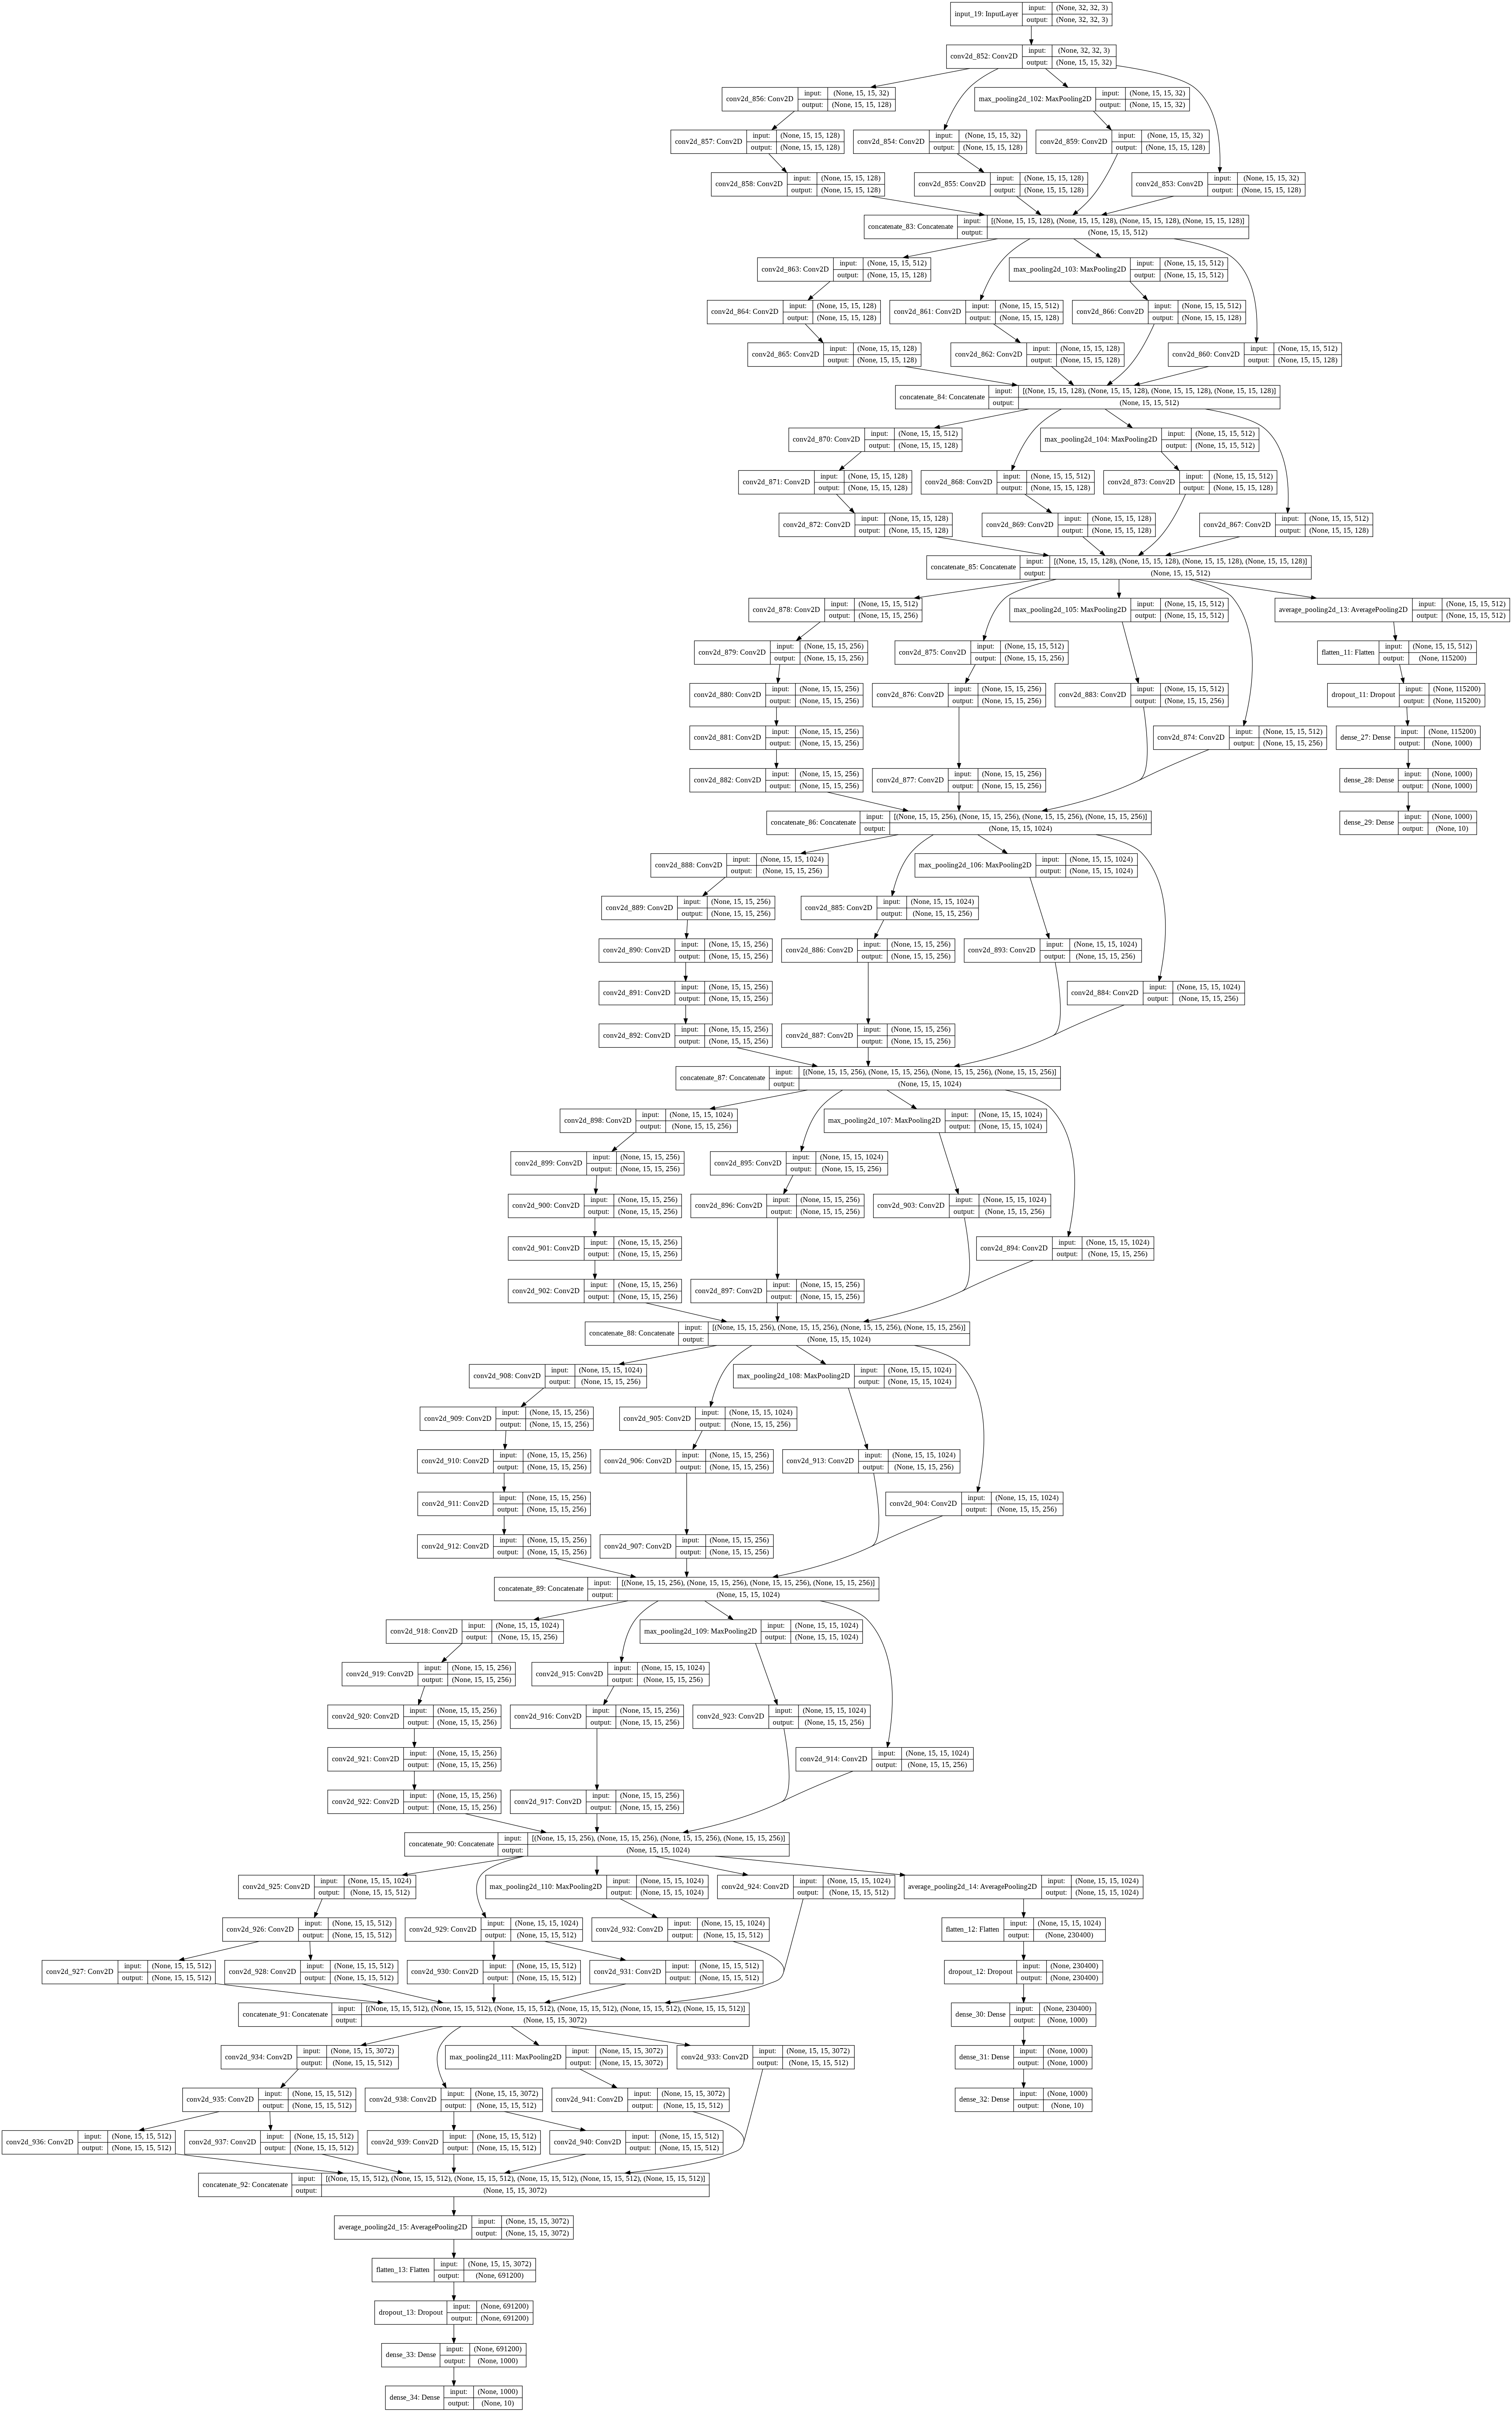

In [0]:
# define model input
visible = Input(shape=(32, 32, 3))
# conv layer1
conv1 = Conv2D(32, (3,3), padding="valid",strides=2 , activation='relu')(visible)
# # conv layer2
# conv2 = Conv2D(32, (3,3), padding="valid",strides=1 , activation='relu')(conv1)
# # conv padded layer3
# conv3 = Conv2D(64, (3,3), padding="same",strides=1 , activation='relu')(conv2)
# #pool
# pool1 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(conv3)
# #conv layer 4
# conv4 = Conv2D(80, (3,3), padding="valid",strides=1 , activation='relu')(pool1)
# #conv layer 5
# conv5 = Conv2D(192, (3,3), padding="valid",strides=2 , activation='relu')(conv4)
# #conv layer 6
# conv6 = Conv2D(288, (3,3), padding="same",strides=1 , activation='relu')(conv5)
# add inception block A
inception_A_1 = inception_module_V3_A(conv1, 128, 128, 128,128)
inception_A_2 = inception_module_V3_A(inception_A_1, 128, 128, 128,128)
inception_A_3 = inception_module_V3_A(inception_A_2, 128, 128, 128,128)
#aux
aux_output_1 = auxiliary_output(inception_A_3)
# add inception block B
inception_B_1 = inception_module_V3_B(inception_A_3, 3, 256, 256, 256, 256)
inception_B_2 = inception_module_V3_B(inception_B_1, 3, 256, 256, 256, 256)
inception_B_3 = inception_module_V3_B(inception_B_2, 3, 256, 256, 256, 256)
inception_B_4 = inception_module_V3_B(inception_B_3, 3, 256, 256, 256, 256)
inception_B_5 = inception_module_V3_B(inception_B_4, 3, 256, 256, 256, 256)
#aux
aux_output_2 = auxiliary_output(inception_B_5)
# add inception block C
inception_C_1 = inception_module_V3_C(inception_B_5, 512, 512, 512, 512)
inception_C_2 = inception_module_V3_C(inception_C_1, 512, 512, 512, 512)
#pool
pool2 = AveragePooling2D(pool_size=(1, 1))(inception_C_2)
#flatten the resulted inception module
dense1 = Flatten()(pool2)
#drop out
drop_1 = Dropout(rate=0.4)(dense1)
# Dense layer
dense2 = Dense(1000, activation='relu')(drop_1)
# define mode output
output = Dense(10, activation='softmax')(dense2)
# create model
inception_V3 = Model(inputs=visible, outputs=[output,aux_output_1,aux_output_2])
# summarize model
inception_V3.summary()
# plot model architecture
plot_model(inception_V3, show_shapes=True, to_file='inception_moduleV3.png')

In [0]:
inception_V3.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'],loss_weights=[0.4, 0.3,0.3])

In [0]:
# Fitting the model
import numpy as np
batch_size = 32   #64
epochs = 2     #150

# Train model (use 10% of training set as validation set)
inception_V3.fit(np.array(training_data), np.array(train_labels), epochs=epochs, batch_size=batch_size, validation_split=0.1, shuffle=True)

In [0]:
# Evaluate the model on Test set

scores = inception_V3.evaluate(x_test, y_test)
print("\nTest %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

NameError: ignored

### LARGE Model Creation

In [0]:
# x_train = np.resize(x_train,(50000,112,112,3))
# print(x_train.shape)
# x_test = np.resize(x_test,(10000,112,112,3))

(50000, 112, 112, 3)


In [0]:
# define model input
visible = Input(shape=(32, 32, 3))
# visible = Input(shape=(112, 112, 3))

# conv layer1
conv1 = Conv2D(32, (3,3), padding="valid",strides=2 , activation='relu')(visible)
'''
# conv layer2
conv2 = Conv2D(32, (3,3), padding="valid",strides=1 , activation='relu')(conv1)
# conv padded layer3
conv3 = Conv2D(64, (3,3), padding="same",strides=1 , activation='relu')(conv2)

#pool
pool1 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(conv3)

#conv layer 4
conv4 = Conv2D(80, (3,3), padding="valid",strides=1 , activation='relu')(pool1)
#conv layer 5
conv5 = Conv2D(192, (3,3), padding="valid",strides=2 , activation='relu')(conv4)
#conv layer 6
conv6 = Conv2D(288, (3,3), padding="same",strides=1 , activation='relu')(conv5)
'''

# add inception block A
inception_A_1 = inception_module_V3_A(conv1, 128, 128, 128, 128)
inception_A_2 = inception_module_V3_A(inception_A_1, 128, 128, 128,128)
inception_A_3 = inception_module_V3_A(inception_A_2, 128, 128, 128,128)

#aux
aux_output_1 = auxiliary_output(inception_A_3,"aux_output_1")

# add inception block B
inception_B_1 = inception_module_V3_B(inception_A_3, 3, 256, 256, 256, 256)
inception_B_2 = inception_module_V3_B(inception_B_1, 3, 256, 256, 256, 256)
inception_B_3 = inception_module_V3_B(inception_B_2, 3, 256, 256, 256, 256)
inception_B_4 = inception_module_V3_B(inception_B_3, 3, 256, 256, 256, 256)
inception_B_5 = inception_module_V3_B(inception_B_4, 3, 256, 256, 256, 256)

#aux
aux_output_2 = auxiliary_output(inception_B_5,"aux_output_2")

# add inception block C
inception_C_1 = inception_module_V3_C(inception_B_5, 512, 512, 512, 512)
inception_C_2 = inception_module_V3_C(inception_C_1, 512, 512, 512, 512)


#pool
pool2 = AveragePooling2D(pool_size=(3, 3))(inception_C_2)


#flatten the resulted inception module
dense1 = Flatten()(pool2)

#drop out
drop_1 = Dropout(rate=0.4)(dense1)

# Dense layer
dense2 = Dense(1000, activation='relu')(drop_1)

# define mode output
output = Dense(10, activation='softmax', name='output')(dense2)

# create model
inception_V3 = Model(inputs=visible, outputs=[output,aux_output_1,aux_output_2])
# inception_V3 = Model(inputs=visible, outputs=output)
# inception_V3 = Model(inputs=visible, outputs=[output,aux_output_1])







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# summarize model
# inception_V3.summary()

# plot model architecture
#plot_model(inception_V3, show_shapes=True, to_file='inception_moduleV3.png')

In [0]:

losses = {
	"output"      : "categorical_crossentropy",
	"aux_output_1": "categorical_crossentropy",
  "aux_output_2": "categorical_crossentropy"
}

lossWeights = {
    "output": 0.4,
	  "aux_output_1": 0.3,
    "aux_output_2": 0.3
    }
 
inception_V3.compile(optimizer='adam', loss=losses, loss_weights=lossWeights, metrics=['accuracy'])

In [0]:
# Fitting the model

batch_size = 32   #64
epochs = 10     #150

# Train model (use 10% of training set as validation set)
inception_V3.fit(x_train,{"output":y_train, "aux_output_1":y_train, "aux_output_2":y_train}, epochs=epochs, batch_size=batch_size, validation_split=0.1, shuffle=True)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 45000 samples, validate on 5000 samples
Epoch 1/10





45000/45000 [==============================] - 1659s 37ms/step - loss: 1.6446 - output_loss: 1.6956 - aux_output_1_loss: 1.5232 - aux_output_2_loss: 1.6980 - output_acc: 0.3697 - aux_output_1_acc: 0.4410 - aux_output_2_acc: 0.3670 - val_loss: 1.2967 - val_output_loss: 1.3413 - val_aux_output_1_loss: 1.1848 - val_aux_output_2_loss: 1.3491 - val_output_acc: 0.5154 - val_aux_output_1_acc: 0.5792 - val_aux_output_2_acc: 0.5004
Epoch 2/10
45000/45000 [==============================] - 1634s 36ms/step - loss: 1.2444 - output_loss: 1.2916 - aux_output_1_loss: 1.1115 - aux_output_2_loss: 1.3143 - output_acc: 0.5326 - aux_output_1_acc: 0.6061 - aux_output_2_acc: 0.5242 - val_loss: 1.0741 - val_output_loss: 1.1235 - val_aux_output_1_loss: 0.9560 - val_aux_output_2_loss: 1.1263 - val_output_acc: 0.6004 - val_aux_output_1_acc: 0.6690 - va

In [0]:
from google.colab import drive

# load an image from google drive
drive.mount('/content/drive')
src = '/content/drive/My Drive/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# import files
# serialize model to JSON
model_json = inception_V3.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
inception_V3.save_weights(src+"model.h5")
print("Saved model to disk")

# files.download("model.h5")

Saved model to disk


#### Results

In [0]:
# Evaluate the model on Test set

scores = inception_V3.evaluate(x_test, {"output":y_test, "aux_output_1":y_test, "aux_output_2":y_test})
print("\nTest %s: %.2f%%" % (inception_V3.metrics_names[1], scores[1]*100))

10000/10000 [==============================] - 102s 10ms/step

Test output_loss: 71.70%


In [0]:
# Plots for training and testing process: loss and accuracy
 
plt.figure(0)
plt.plot(inception_V3.history['acc'],'r')
plt.plot(inception_V3.history['val_acc'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(inception_V3.history['loss'],'r')
plt.plot(inception_V3.history['val_loss'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
  
plt.show()